In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import math
from PIL import Image

In [10]:
def load_data(seed):
    nTotal = 20000
    
    X = np.zeros((nTotal, 784))
    Y = np.zeros((nTotal, 2))
    count = 0
    for dirname, _, filenames in os.walk('Datasets'):
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename)).resize((28,28))
            
            data = np.asarray(image, dtype='float64').reshape(1, -1)

            data = data / 255
            
            X[count] = data
            if count == 0:
                print("Data shape ", data.shape)
                print(data)
                plt.imshow(image)
            if(count < nTotal / 2):
                # Y[count] = 0
                Y[count] = np.array([1, 0])
            elif(count < nTotal):
                # Y[count] = 1
                Y[count] = np.array([0, 1])
            
            count += 1

    np.random.seed(seed)

    indices = list(np.random.permutation(nTotal))
    X = X[indices]
    Y = Y[indices]

    nTrain = int(nTotal * 0.9)
    nDev = int(nTotal * 0.05)
    nTest = int(nTotal * 0.05)

    trainX = X[: nTrain]
    trainY = Y[: nTrain]
    
    devX = X[nTrain : nDev]
    devY = Y[nTrain : nDev]

    testX = X[nDev : nTest]
    testY = Y[nDev : nTest]
    
    return trainX.T, trainY.T, devX.T, devY.T, testX.T, testY.T

Data shape  (1, 784)
[[0.6        0.60392157 0.60392157 0.60784314 0.60392157 0.60392157
  0.60392157 0.60392157 0.58431373 0.54117647 0.5254902  0.53333333
  0.50980392 0.49411765 0.51764706 0.57254902 0.60392157 0.61176471
  0.61568627 0.62745098 0.62352941 0.62352941 0.62352941 0.61960784
  0.61960784 0.61960784 0.63529412 0.63921569 0.60784314 0.60784314
  0.6        0.60784314 0.60784314 0.61176471 0.6        0.54509804
  0.50980392 0.40392157 0.37254902 0.35294118 0.30980392 0.29411765
  0.3372549  0.43529412 0.52156863 0.60784314 0.62745098 0.61960784
  0.62745098 0.63137255 0.63137255 0.62352941 0.61960784 0.61960784
  0.63529412 0.63137255 0.60784314 0.61568627 0.60392157 0.61176471
  0.62352941 0.61176471 0.4627451  0.40392157 0.38823529 0.31372549
  0.28627451 0.28627451 0.3254902  0.34509804 0.35294118 0.36862745
  0.41568627 0.49019608 0.56078431 0.62352941 0.63529412 0.63529412
  0.62745098 0.63137255 0.61960784 0.62745098 0.62352941 0.62745098
  0.58039216 0.58823529 0.6

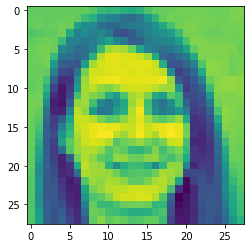

In [11]:
trainX, trainY, devX, devY, testX, testY = load_data(1)

In [62]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(2, 10) - 0.5
    b2 = np.random.rand(2, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    # print("One hot Y", one_hot_Y)
    # print("One hot Y shape", one_hot_Y.shape)
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, prin):
    m = X.shape[1]
    # one_hot_Y = one_hot(Y)
    one_hot_Y = Y
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [69]:
def get_predictions(A2):
    return np.rint(A2)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def real_accurracy(A2, Y):
    total = 0
    for i in range(18000):
        if A2[0, i] > A2[1, i] and Y[0, i] == 1:
            total += 1
        elif A2[0, i] < A2[1, i] and Y[1, i] == 1:
            total += 1
    return total / (Y.size / 2)


def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        prin = False
        if i == iterations - 1:
            prin = True
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, prin)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            # print(real_accurracy(A2, Y))
    return W1, b1, W2, b2

In [70]:
W1, b1, W2, b2 = gradient_descent(trainX, trainY, 0.10, 500)

Iteration:  0
0.5092222222222222
Iteration:  10
0.783
Iteration:  20
0.8908888888888888
Iteration:  30
0.9322222222222222
Iteration:  40
0.8486666666666667
Iteration:  50
0.9306666666666666
Iteration:  60
0.9682777777777778
Iteration:  70
0.9742222222222222
Iteration:  80
0.5015
Iteration:  90
0.9630555555555556
Iteration:  100
0.9794444444444445
Iteration:  110
0.9844444444444445
Iteration:  120
0.9865
Iteration:  130
0.9881111111111112
Iteration:  140
0.9896111111111111
Iteration:  150
0.9903333333333333
Iteration:  160
0.9911666666666666
Iteration:  170
0.9918888888888889
Iteration:  180
0.9921666666666666
Iteration:  190
0.9927222222222222
Iteration:  200
0.9932222222222222
Iteration:  210
0.9938888888888889
Iteration:  220
0.9940555555555556
Iteration:  230
0.9944444444444445
Iteration:  240
0.9946666666666667
Iteration:  250
0.9951111111111111
Iteration:  260
0.9954444444444445
Iteration:  270
0.9955555555555555
Iteration:  280
0.9956666666666667
Iteration:  290
0.995888888888888

In [71]:
print(trainY.shape)
print(trainY)
print(trainY[:, 0])
print(trainY[:, 17997])
print(trainY[:, 17999])

(2, 18000)
[[0. 0. 1. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]]
[0. 1.]
[1. 0.]
[0. 1.]
